<a href="https://colab.research.google.com/github/valerio-unifei/ECO904/blob/main/ECO904_2024_1_Atividade_2_Etapa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 2 - Etapa 2

[Proposta](https://docs.google.com/document/d/e/2PACX-1vTvlDZCbl8BtQfBQ3a0CPt_KDnxzQx_8E18iJMJxZ5R05cgX18hx0R8iwd5g3didFwDUHpJRRkqqQqs/pub)

Utilizar uma rede CNN pré-treinada:
- Escolher o modelo de rede
- Realizar transferência de aprendizado
- Verificar resultados e tempo de aprendizagem

## Base de Dados

In [ ]:
import os
from google.colab import files, userdata

if not os.path.exists('/content/data'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'smaranjitghose/corn-or-maize-leaf-disease-dataset'
  !unzip -qq corn-or-maize-leaf-disease-dataset.zip
  !rm corn-or-maize-leaf-disease-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
100% 161M/161M [00:08<00:00, 23.6MB/s]
100% 161M/161M [00:08<00:00, 19.8MB/s]


### Carregando Dataset em Tensor do pyTorch

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split

# Defina o diretório raiz onde estão suas pastas de treinamento e validação
root_dir = '/content/data'

# Defina as transformações que deseja aplicar às suas imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajuste o tamanho conforme necessário
    transforms.ToTensor(),           # Converta a imagem para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização
])

# Crie o dataset ImageFolder
dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)

# Divida o dataset em conjuntos de treinamento e validação
train_size = int(0.8 * len(dataset))  # 80% para treinamento
val_size = len(dataset) - train_size   # 20% para validação

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val':DataLoader(val_dataset, batch_size=32, shuffle=False),
    }

dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset)}

print('Classes:',dataset.classes)

Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualizando Dados

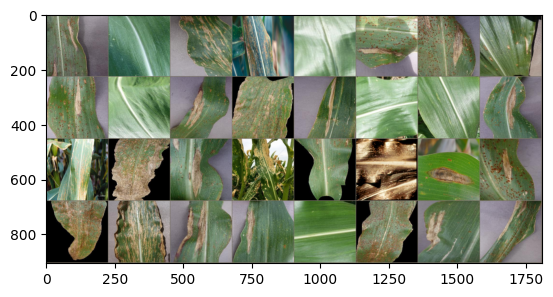

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# imshow para imagens em tensores
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title='\n'.join([dataset.classes[x] for x in classes]))
imshow(out)

## ResNet versão 18

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


### Transfer Learning

In [ ]:
import time
import copy

def treinamento(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Época {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
          scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Perda: {epoch_loss:.4f} Acur: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Treinamento completo em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Melhor acurácia: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

model_ft = treinamento(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Época 0/4
----------
train Perda: 0.4478 Acur: 0.8376
val Perda: 0.1850 Acur: 0.9344

Época 1/4
----------
train Perda: 0.1530 Acur: 0.9475
val Perda: 0.1729 Acur: 0.9368

Época 2/4
----------
train Perda: 0.0889 Acur: 0.9728
val Perda: 0.1337 Acur: 0.9475

Época 3/4
----------
train Perda: 0.0588 Acur: 0.9839
val Perda: 0.1333 Acur: 0.9487

Época 4/4
----------
train Perda: 0.0387 Acur: 0.9913
val Perda: 0.1356 Acur: 0.9499

Treinamento completo em 2m 20s
Melhor acurácia: 0.949881


### Salvando o modelo treinado

In [ ]:
arquivo_modelo = 'folhasMilhoDP.pth'
torch.save(model_ft,arquivo_modelo)
from google.colab import files
files.download(arquivo_modelo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Avaliando o Treinamento

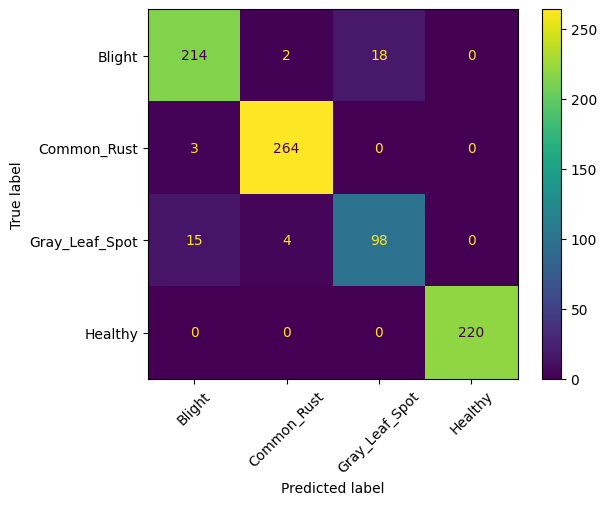

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'val_loader' is your validation dataloader
preds = []
true_labels = []

# Iterate through the validation dataloader
with torch.no_grad():  # No need to calculate gradients for validation
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to NumPy
        true_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, preds)

labels = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

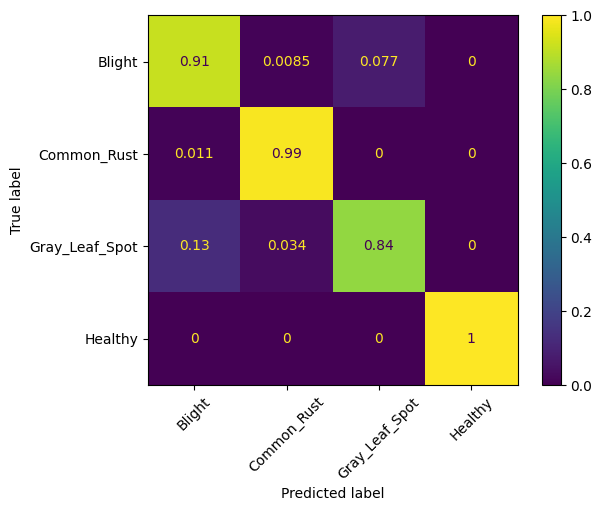

In [ ]:
cm = confusion_matrix(true_labels, preds, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### Caso precise caregar o arquivo de modelo salvo

In [ ]:
from google.colab import files
conteudo = files.upload()
arquivo_modelo = list(conteudo.keys())[0]
model_ft = torch.load(arquivo_modelo)
model_ft.eval()